# Brain Tumor Detection using Convolutional Neural Networks

## Setting up Enviroment

The following are necessary packages for running this notebook.

In [1]:
import os
import pathlib
import cv2
import imutils

### Basics
import numpy as np
import matplotlib.pyplot as plt

## Data Processing

#### The data for this notebook can be found at https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

Below we will prepare the data for testing.

### Cropping Data to be Standardized using Contours
We will be using the contouring concept covered in this article: https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/. 

In [2]:
def crop_brain_contour(image):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    return new_image

In [3]:
# Gets image paths. data_path = path to directory containing images
def getImagePaths(data_path):
    paths = []
    for r, _, f in os.walk(f'{data_path}'):
        for file in f:
            if not file.startswith('.'):
                paths.append(os.path.join(r, file))
    return paths

In [4]:
# Reads, crops, and resizes images and returns X and y values.
def populateXandY(paths, img_size=(100, 100)):
    X = []
    y = []
    for i, imagePaths in enumerate(paths):
        for image in imagePaths:
            img = cv2.imread(image)
            img = crop_brain_contour(img)
            img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
            X.append(img)
            y.append(i)
    return np.array(X), np.array(y).reshape((-1, 1))

In [5]:
# Assuming this path exists in Current Working Directory
data_path = "./data/brain_tumor_dataset/"

# Load folders Yes and No separately.
yes_paths = getImagePaths(f'{data_path}yes')
no_paths = getImagePaths(f'{data_path}no')

# Note: Ordering matters since we let enumerate create classes above.
X, y = populateXandY([no_paths, yes_paths], img_size=(224, 224))

X.shape, y.shape

((253, 224, 224, 3), (253, 1))

### Splitting the data

Below we split the data using the splitting algorithm from A3 in CS445.

The data will be split into 60% training, 20% testing, and 20% validation sets

In [6]:
# Splits the data into train, test, and validation sets.
def train_test_validation(X, y, randSeed=None):
    # If random seed is given, set seed.
    if randSeed:
        np.random.seed(randSeed)
    
    # Randomly order X and T
    randorder = np.arange(X.shape[0])
    np.random.shuffle(randorder)
    X = X[randorder, :]
    y = y[randorder, :]
    
    n_folds = 5
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds 
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  # handles case when n_samples not evenly divided by n_folds

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], y[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], y[start: ,]) )
    
    X_validate, T_validate = folds[0]
    X_test, T_test = folds[1]
    X_train, T_train = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]])
    return X_train, T_train, X_test, T_test, X_validate, T_validate

In [7]:
# Note: Running with random seed 42. Leave randSeed empty or randSeed=None if no seed.
X_train, T_train, X_test, T_test, X_validate, T_validate = train_test_validation(X, y, randSeed=42)

X_train.shape, T_train.shape, X_test.shape, T_test.shape, X_validate.shape, T_validate.shape

((153, 224, 224, 3),
 (153, 1),
 (50, 224, 224, 3),
 (50, 1),
 (50, 224, 224, 3),
 (50, 1))

## Lets Visualize Our Data

Below we will preview the first 50 elements in the training set.

In [8]:
# Plots n elements (10 per row) and whether the image is a tumor or not.
def plot_sample_images(X, y, n=50):
    columns_n = 10
    rows_n = int(n / columns_n)
    
    plt.figure(figsize=(20, 16))
    
    for i in range(n):
        plt.subplot(rows_n, columns_n, i + 1)
        plt.imshow(X[i])
        plt.title("Yes" if y[i] == 1 else "No", fontsize='x-large')
        plt.axis('off')
    plt.show()

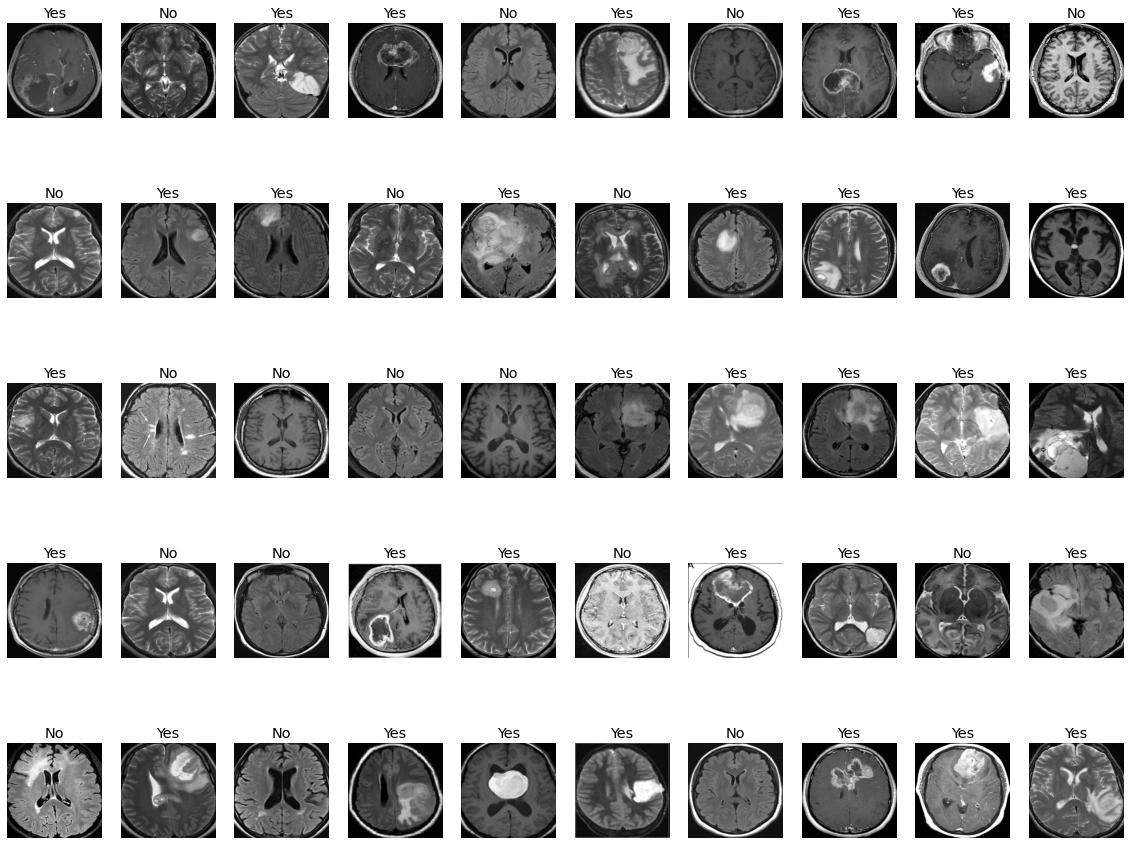

In [9]:
plot_sample_images(X_train, T_train)